In [1]:
import numpy as np
import tensorflow.keras.datasets as datasets
import matplotlib.pyplot as plt

/Users/radubuzas/PycharmProjects/DigitDetection/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)

(60000, 28, 28)


In [3]:
n = x_train.shape[0]
x_train = x_train.reshape(n, -1)
x_train = x_train / 255

x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test / 255

print(x_train.shape)

(60000, 784)


In [4]:
n = x_test.shape[0]
x_test = x_test.reshape(n, -1)

print(x_test.shape)

(10000, 784)


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [8]:
def one_hot(y):
    n = y.shape[0]
    k = np.max(y) + 1
    y_one_hot = np.zeros((n, k))
    y_one_hot[np.arange(n), y] = 1
    return y_one_hot

In [118]:
class NN:
    def __init__(self, x, y, alpha=0.01, epochs=1000, batch_size=100, architecture=(10, 10)):
        self.x = x
        self.y = y
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size

        self.architecture_size = len(architecture)
        self.layers = architecture

        self.Z = [None] * self.architecture_size
        self.a = [None] * self.architecture_size

        self.W = [None] * self.architecture_size
        self.b = [None] * self.architecture_size

        self.W[0] = np.random.randn(x.shape[1], self.layers[0])                 # 784 x 10
        self.b[0] = np.random.randn(1, self.layers[0])                          # 1 x 10

        for i in range(1, self.architecture_size):
            self.W[i] = np.random.randn(self.layers[i - 1], self.layers[i])     # 10 x 10
            self.b[i] = np.random.randn(1, self.layers[i])                      # 1 x 10

    def feedforward(self, x=None) -> ():
        if x is None:
            x = self.x

        self.Z[0] = np.dot(x, self.W[0]) + self.b[0]            # n x 784 @ 784 x 10 + 1 x 10 = n x 10
        self.a[0] = sigmoid(self.Z[0])                          # n x 10

        for i in range(1, self.architecture_size):
            self.Z[i] = np.dot(self.a[i - 1], self.W[i]) + self.b[i]   # n x 10 * 10 x 10 + 1 x 10 = n x 10
            self.a[i] = sigmoid(self.Z[i])                    # n x 10

        n = self.architecture_size - 1

        self.Z[n] = np.dot(self.a[n-1], self.W[n]) + self.b[n]    # n x 10 * 10 x 10 + 1 x 10 = n x 10
        self.a[n] = softmax(self.Z[n])                          # n x 10

    def test(self, x: np.array, y: np.array) -> float:
        self.feedforward(x)
        n = self.architecture_size - 1
        r = np.argmax(self.a[n], 1)
        return np.mean(r == y)

    def test_iamge(self, image: np.array) -> np.array:
        self.feedforward(image)
        n = self.architecture_size - 1
        return np.argmax(self.a[n][0])

    def backprop(self, alpha=0):
        if alpha == 0:
            alpha = self.alpha

        m = self.y.shape[0]
        n = self.architecture_size - 1

        dZ = [None] * self.architecture_size
        dW = [None] * self.architecture_size
        db = [None] * self.architecture_size

        one_hot_y = one_hot(self.y)

        dZ[n] = self.a[n] - one_hot_y
        dW[n] = np.dot(self.a[n-1].T, dZ[n]) / m
        db[n] = np.sum(dZ[n], axis=0, keepdims=True) / m


        for i in range(n-1, 0, -1):
            dZ[i] = np.dot(dZ[i+1], self.W[i+1].T) * sigmoid_derivative(self.Z[i])
            dW[i] = np.dot(self.a[i-1].T, dZ[i]) / m
            db[i] = np.sum(dZ[i], axis=0, keepdims=True) / m

        dZ[0] = np.dot(dZ[1], self.W[1].T) * sigmoid_derivative(self.Z[0])
        dW[0] = np.dot(self.x.T, dZ[0]) / m
        db[0] = np.sum(dZ[0], axis=0, keepdims=True) / m

        for i in range(self.architecture_size):
            self.W[i] -= alpha * dW[i]
            self.b[i] -= alpha * db[i]

    def get_accuracy(self):
        n = self.architecture_size - 1
        return np.mean(np.argmax(self.a[n], 1) == self.y)

    def SGD(self, alpha=0, epochs=0):
        if alpha == 0:
            alpha = self.alpha
        if epochs == 0:
            epochs = self.epochs
        for i in range(epochs):
            # for j in range(0, self.x.shape[0], self.batch_size):
            #     x_batch = self.x[j:j + self.batch_size]
            #     y_batch = self.y[j:j + self.batch_size]
            #     self.feedforward(x_batch)
            #     self.backprop(x_batch, y_batch)
            self.feedforward()
            self.backprop(alpha=alpha)
            if i % 10 == 0:
                print('Iteration:', i, 'Accuracy', self.get_accuracy())

In [119]:
def print_image(x):
    plt.imshow(x.reshape(28, 28), cmap='gray')

In [136]:
nn = NN(x_train, y_train, alpha=0.2, epochs=1000, batch_size=100, architecture=(10, 10))

In [140]:
# nn.SGD(alpha=5, epochs=500)
# nn.SGD(alpha=1, epochs=100)
nn.SGD(alpha=0.2, epochs=1000)

Iteration: 0 Accuracy 0.8992
Iteration: 10 Accuracy 0.8992
Iteration: 20 Accuracy 0.8992333333333333
Iteration: 30 Accuracy 0.8992166666666667
Iteration: 40 Accuracy 0.89925
Iteration: 50 Accuracy 0.8992833333333333
Iteration: 60 Accuracy 0.8992833333333333
Iteration: 70 Accuracy 0.8993
Iteration: 80 Accuracy 0.8993166666666667
Iteration: 90 Accuracy 0.8993166666666667
Iteration: 100 Accuracy 0.8993166666666667
Iteration: 110 Accuracy 0.8993333333333333
Iteration: 120 Accuracy 0.8993333333333333
Iteration: 130 Accuracy 0.8993666666666666
Iteration: 140 Accuracy 0.8994166666666666
Iteration: 150 Accuracy 0.8994833333333333
Iteration: 160 Accuracy 0.8994833333333333
Iteration: 170 Accuracy 0.8995
Iteration: 180 Accuracy 0.8994666666666666
Iteration: 190 Accuracy 0.8995
Iteration: 200 Accuracy 0.8995333333333333
Iteration: 210 Accuracy 0.8995166666666666
Iteration: 220 Accuracy 0.8995333333333333
Iteration: 230 Accuracy 0.8995
Iteration: 240 Accuracy 0.8994833333333333
Iteration: 250 Accu

In [141]:
# get random image
def get_random_image(nn: NN):
    i = np.random.randint(0, x_test.shape[0])
    x = x_test[i].reshape(1, -1)
    print_image(x)

    print('Image:', i)
    print('Actual:', y_test[i])
    print('Predicted:', nn.test_iamge(x))

Image: 1226
Actual: 7
Predicted: 2


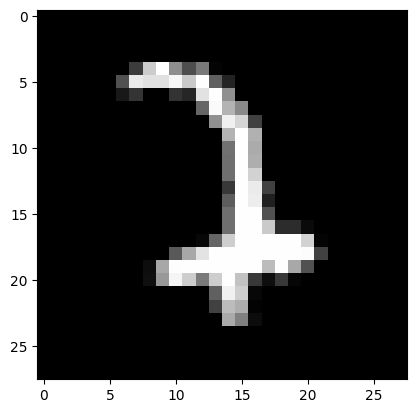

In [153]:
get_random_image(nn)

In [155]:
nn.test(x_train, y_train)

0.9010833333333333

In [158]:
nn.test(x_test, y_test)

0.8989